In [2]:
def grid_dicto_to_df_list(grid_list):
    list_to_df = []
    non_metrics = ['proba_outputs', 'actual_classes', 'proba_outputs', 'actual_classes', 'test_proba', 'test_actual_classes']
    for dict_hyper in grid_list:
        dict_to_df = {}
        # print(dict_hyper)
        for val in dict_hyper.values():
            for item in val.items():
                if type(item[1]) != dict:
                    dict_to_df[item[0]] = item[1]
                else:
                    dictionary_results = item[1]
                    for item in dictionary_results.items(): 
                        if item[0] not in non_metrics:
                            dict_to_df[item[0]] = item[1]
        list_to_df.append(dict_to_df)
    return list_to_df

# Initial grid analysis of INDIVIDUAL DETERMINANT models

In [3]:
import pandas as pd 
import json
import pprint

In [4]:
with open("metrics_ind_dets_final.json") as f:
    grids = json.load(f)

In [5]:
len(grids)

2

In [6]:
list_to_df = grid_dicto_to_df_list(grids)

In [7]:
df = pd.DataFrame(list_to_df)

In [8]:
# pprint.pprint(list(df.columns))

In [9]:
df.head()

,MAX-LEN,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,40,0.010757,0.058637,0.0,0.0,0.5,...,0.472222,0.756954,0.040123,"[[[0.002359763951972127, 0.0017265485366806388...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.069249,0.457143,0.667978,0.052778,0.35
1,128,0.00005,8,40,40,0.010271,0.049880,0.0,0.0,0.5,...,0.388889,0.718765,0.049383,"[[[0.001291175838559866, 0.0006883626920171082...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.074912,0.444444,0.666495,0.055556,0.30


In [10]:
def get_best_scores(df):

    cols_min = [ "train_loss_epoch", "valid_loss_epoch", "hamming_epoch"]

    for col in cols_min:
        filter_df = df.filter(regex=(col))
        # print(filter_df)
        minimum = filter_df.min(axis=1)
        
        name = col.split("epoch")[0]
        name_col = "best_{}".format(name)
        # print(minimum)
        df[name_col] = minimum
        
    cols_max = ["f1_epoch", "accuracy_epoch", "roc_auc_epoch"]
    
    for col in cols_max:
        filter_df = df.filter(regex=(col))
        max_ = filter_df.max(axis=1)
        name = col.split("epoch")[0]
        name_col = "best_{}".format(name)
        df[name_col] = max_
    
    return df

In [11]:
df_bests = get_best_scores(df)

In [12]:
names_cols = [col for col in df.columns if "best_" in col and "roc" not in col]

In [13]:
names_cols

['best_train_loss_',
 'best_valid_loss_',
 'best_hamming_',
 'best_f1_',
 'best_accuracy_']

In [14]:
filter_columns = ["learning_rate", "batch_size", "test_loss", "test_f1", "test_hamming"] + names_cols

## Comparing model performance

In [15]:
df_bests[filter_columns].sort_values(["best_valid_loss_"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00003,8,0.069249,0.457143,0.052778,0.000402,0.034424,0.037037,0.637681,0.472222
1,0.00005,8,0.074912,0.444444,0.055556,0.000236,0.038539,0.046296,0.558824,0.416667


<!-- We can see that generally the lower the batch size the faster a model will learn and the better a model will perform.

We can scratch bath size 64 since we would need a higher learning rate and we may lose control of the pace of learning.  -->

## Visualizing the candidate models

In [16]:
model_5_batch_8 = df.iloc[1]
model_3_batch_8 = df.iloc[0]

In [17]:
model_3_batch_8.keys()

Index(['MAX-LEN', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy',
       'best_train_loss_', 'best_valid_loss_', 'best_hamming_', 'best_f1_',
       'best_accuracy_', 'best_roc_auc_'],
      dtype='object', length=343)

In [18]:
# df[2]

Little function to get the info that we want to plot

In [19]:
def get_train_val_metric_df(model):
    
    """Turn a row into a more easily plot-able df 
    
    """
    
    train_loss = [model[col] for col in model.keys() if "train_loss_" in str(col) and "best" not in str(col)]    
    valid_loss = [model[col] for col in model.keys() if "valid_loss_" in str(col) and "best" not in str(col)]
    metric = [model[col] for col in model.keys() if "hamming_epoch" in str(col) and "best" not in str(col)]
    epochs = [n for n in range(1,41)]

    train_df = pd.DataFrame(train_loss, columns=["train_loss"], index=epochs)
    val_df = pd.DataFrame(valid_loss, columns=["valid_loss"], index=epochs)
    metric_df = pd.DataFrame(metric, columns=["hamming"], index=epochs)
    epochs_df = pd.DataFrame(epochs, columns=["epoch"], index=epochs)
    
    df_evaluate = pd.concat([train_df, val_df, metric_df, epochs_df], axis=1)
    
    return df_evaluate

In [20]:
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)

#### Plots

In [21]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

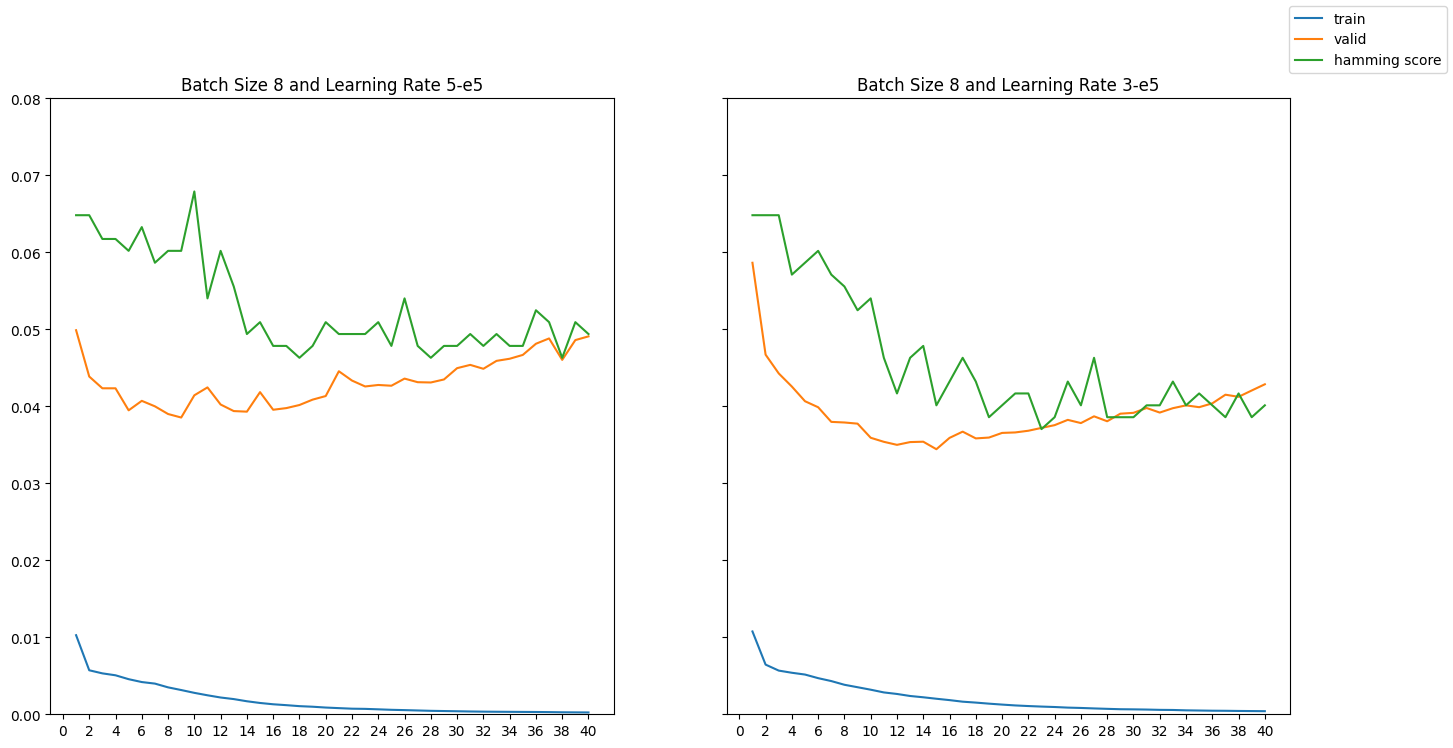

In [22]:
from matplotlib.pyplot import xticks


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

fig.set_figheight(8)
fig.set_figwidth(16)
# fig.suptitle("INDIVIDUAL DETERMINANT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0, 0.08)

ax[0].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"], label="train")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"], label="hamming score")

ax[1].set_ylim(0, 0.08)

ax[1].title.set_text("Batch Size 8 and Learning Rate 3-e5")
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])
xticks(np.arange(0, 41, 2))

fig.legend()
plt.show()

# Initial grid analysis of INDIVIDUAL CONTENT models

In [23]:
with open("metrics_ind_conts_final.json") as f:
    grids = json.load(f)

In [24]:
len(grids)

2

In [25]:
list_to_df = grid_dicto_to_df_list(grids)

In [26]:
df = pd.DataFrame(list_to_df)

In [27]:
df.columns

Index(['MAX-LEN', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'accuracy_epoch_40', 'roc_auc_epoch_40', 'hamming_epoch_40',
       'proba_outputs_epoch_40', 'actual_classes_epoch_40', 'test_loss',
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy'],
      dtype='object', length=337)

In [28]:
df.head()

,MAX-LEN,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,40,0.012002,0.047914,0.0,0.0,0.5,...,0.512195,0.770464,0.030714,"[[[0.028505565598607063, 0.06600934267044067, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.019078,0.666667,0.788317,0.022544,0.478261
1,128,0.00005,12,40,40,0.015858,0.067603,0.0,0.0,0.5,...,0.536585,0.823183,0.027100,"[[[0.008719442412257195, 0.017670029774308205,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.028555,0.739130,0.849979,0.019324,0.652174


In [29]:
df_bests = get_best_scores(df)

## Comparing model performance

In [30]:
df_bests[filter_columns].sort_values("test_loss", ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00003,8,0.019078,0.666667,0.022544,0.000626,0.013704,0.026197,0.651163,0.560976
1,0.00005,12,0.028555,0.739130,0.019324,0.000743,0.023441,0.024390,0.696629,0.560976


## Visualizing the candidate models

In [31]:
model_5_batch_12 = df.iloc[1]
model_3_batch_8 = df.iloc[0]

In [32]:
df_model_5_batch_12 = get_train_val_metric_df(model_5_batch_12)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)

#### Plots

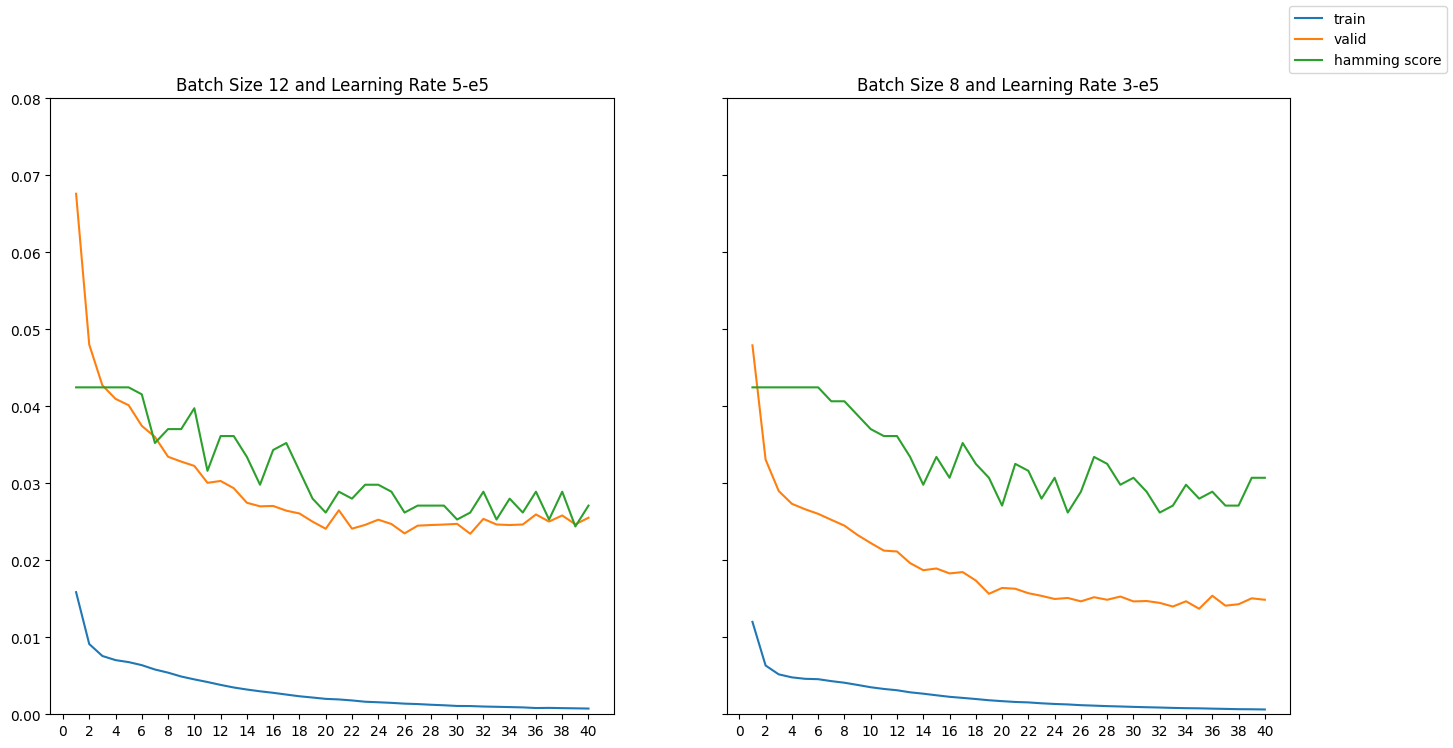

In [33]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

fig.set_figheight(8)
fig.set_figwidth(16)
# fig.suptitle("INDIVIDUAL CONTENT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0, 0.08)

ax[0].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["train_loss"], label="train")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["hamming"], label="hamming score")

ax[1].set_ylim(0, 0.08)

ax[1].title.set_text("Batch Size 8 and Learning Rate 3-e5")
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])

xticks(np.arange(0, 41, 2))

fig.legend()
plt.show()

# Initial grid analysis of MACRO DETERMINANT models

In [34]:
with open("metrics_macro_dets_final.json") as f:
    grids = json.load(f)
    
grids = grids[-9:]

In [35]:
list_to_df = grid_dicto_to_df_list(grids)

In [36]:
df = pd.DataFrame(list_to_df)

In [37]:
# df.columns

In [38]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00002,8,40,40,0.013889,0.100558,0.153846,0.027778,0.530749,...,0.500000,0.777406,0.138889,"[[[0.019337741658091545, 0.0005331491120159626...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.325196,0.545455,0.693662,0.210526,0.421053
1,128,0.00005,8,40,40,0.013563,0.100638,0.000000,0.000000,0.500000,...,0.555556,0.815508,0.127778,"[[[0.003231522860005498, 0.0009104532655328512...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.282990,0.638298,0.756162,0.178947,0.578947
2,128,0.00005,12,40,40,0.019716,0.161645,0.000000,0.000000,0.500000,...,0.527778,0.796791,0.144444,"[[[0.002687903353944421, 0.0004782536998391151...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.380904,0.636364,0.749413,0.168421,0.526316


In [39]:
df_best = get_best_scores(df)

## Comparing model performance

In [40]:
df_best[filter_columns].sort_values(["test_loss"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
1,0.00005,8,0.282990,0.638298,0.178947,0.000065,0.070762,0.111111,0.761905,0.611111
0,0.00002,8,0.325196,0.545455,0.210526,0.000185,0.079192,0.127778,0.708861,0.583333
2,0.00005,12,0.380904,0.636364,0.168421,0.000166,0.127517,0.133333,0.714286,0.555556


THERE IS A WRONG ONE

## Visualizing the candidate models

In [41]:
model_2_batch_8 = df.iloc[0]
model_5_batch_8 = df.iloc[1]
model_5_batch_12 = df.iloc[2]

In [42]:
df_model_2_batch_8 = get_train_val_metric_df(model_2_batch_8)
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)
df_model_5_batch_12 = get_train_val_metric_df(model_5_batch_12)

#### Plots

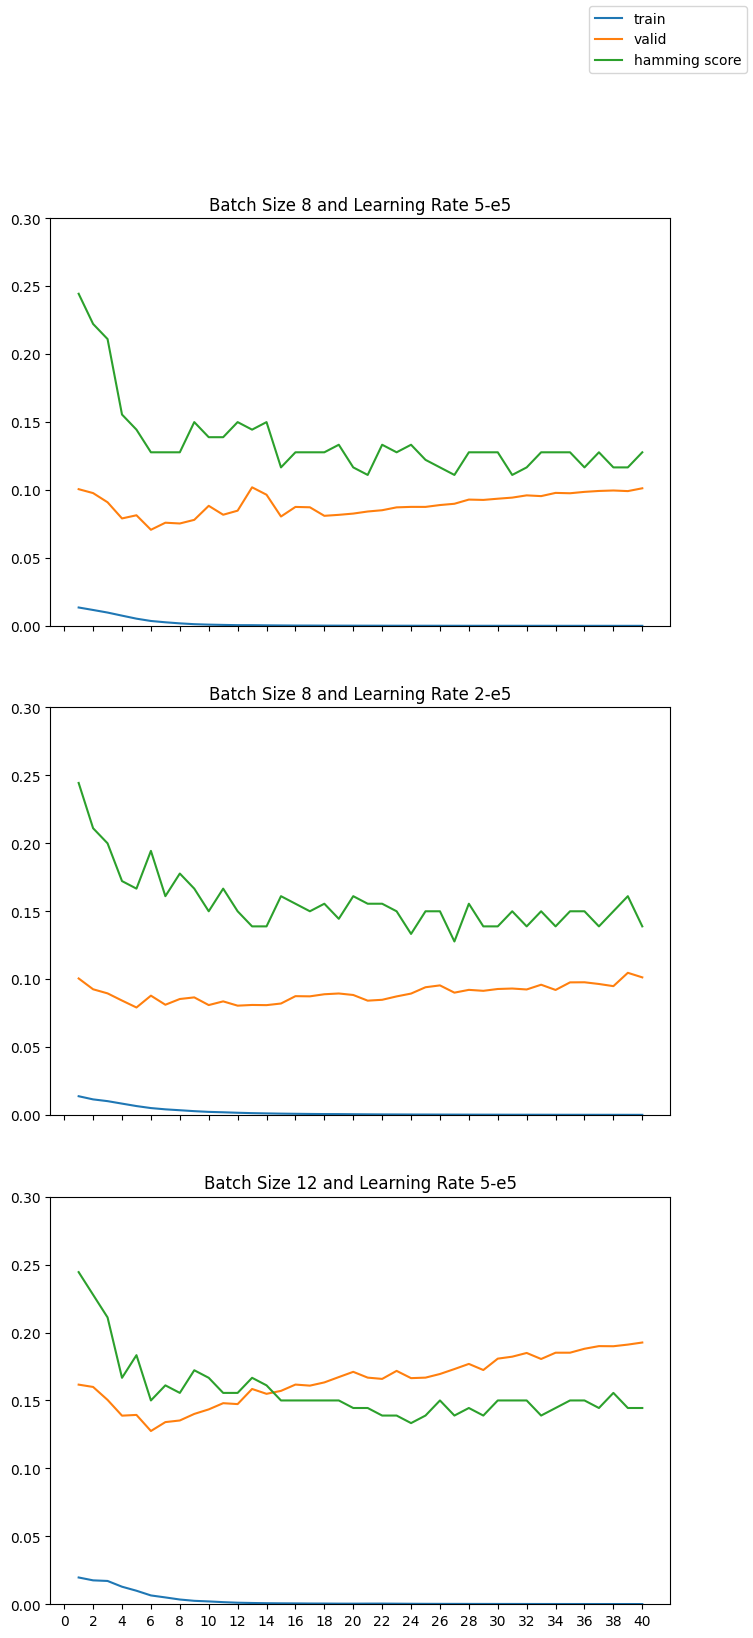

In [43]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_figheight(18)
fig.set_figwidth(8)
# fig.suptitle("MACRO DETERMINANT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0,0.3)

ax[0].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"], label="train")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"], label="hamming score")


# ax[0, 1].set_ylim(0,0.15)

# ax[0, 1].title.set_text("Batch Size 8 and Learning Rate 3-e5")
# ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
# ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
# ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])


ax[1].set_ylim(0,0.3)

ax[1].title.set_text("Batch Size 8 and Learning Rate 2-e5")
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["train_loss"])
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["valid_loss"])
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["hamming"])

ax[2].set_ylim(0,0.3)

ax[2].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[2].plot(df_model_5_batch_12.index, df_model_5_batch_12["train_loss"])
ax[2].plot(df_model_5_batch_12.index, df_model_5_batch_12["valid_loss"])
ax[2].plot(df_model_5_batch_12.index, df_model_5_batch_12["hamming"])
xticks(np.arange(0, 41, 2))


fig.legend()
plt.show()

# Initial grid analysis of MACRO CONTENT models

In [44]:
with open("metrics_macro_conts_final.json") as f:
    grids = json.load(f)


In [45]:
list_to_df = grid_dicto_to_df_list(grids)

In [46]:
df = pd.DataFrame(list_to_df)

In [47]:
df.columns

Index(['max-len', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'accuracy_epoch_40', 'roc_auc_epoch_40', 'hamming_epoch_40',
       'proba_outputs_epoch_40', 'actual_classes_epoch_40', 'test_loss',
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy'],
      dtype='object', length=337)

In [48]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,40,0.010932,0.061307,0.383562,0.351351,0.640813,...,0.756757,0.897361,0.036855,"[[[0.9938198924064636, 0.10873058438301086, 0....","[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0.030007,0.826087,0.903911,0.033058,0.772727
1,128,0.00005,8,40,40,0.010211,0.057183,0.000000,0.000000,0.500000,...,0.729730,0.897361,0.036855,"[[[0.9951241612434387, 0.42797327041625977, 0....","[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0.043789,0.816327,0.921084,0.037190,0.681818
2,128,0.00002,8,40,40,0.011716,0.066406,0.000000,0.000000,0.500000,...,0.783784,0.889854,0.031941,"[[[0.9515544176101685, 0.44403359293937683, 0....","[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0.033590,0.826087,0.903911,0.033058,0.772727
3,128,0.00005,12,40,40,0.016684,0.078777,0.163265,0.108108,0.543764,...,0.783784,0.887107,0.036855,"[[[0.9908204674720764, 0.016482345759868622, 0...","[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0.049660,0.826087,0.903911,0.033058,0.772727


In [49]:
df_best = get_best_scores(df)

## Comparing Model performance

In [50]:
df_best[filter_columns].sort_values(["test_loss"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00003,8,0.030007,0.826087,0.033058,0.000244,0.027342,0.034398,0.829268,0.783784
2,0.00002,8,0.033590,0.826087,0.033058,0.000428,0.020972,0.024570,0.875000,0.810811
1,0.00005,8,0.043789,0.816327,0.037190,0.000147,0.028184,0.036855,0.823529,0.756757
3,0.00005,12,0.049660,0.826087,0.033058,0.000303,0.054513,0.031941,0.839506,0.783784


In [51]:
model_2_batch_8 = df.iloc[2]
model_3_batch_8 = df.iloc[0]
model_5_batch_8 = df.iloc[1]
model_5_batch_12 = df.iloc[3]

In [52]:
df_model_2_batch_8 = get_train_val_metric_df(model_2_batch_8)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)
df_model_5_batch_12 = get_train_val_metric_df(model_5_batch_12)
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)

## Viz

#### Plots

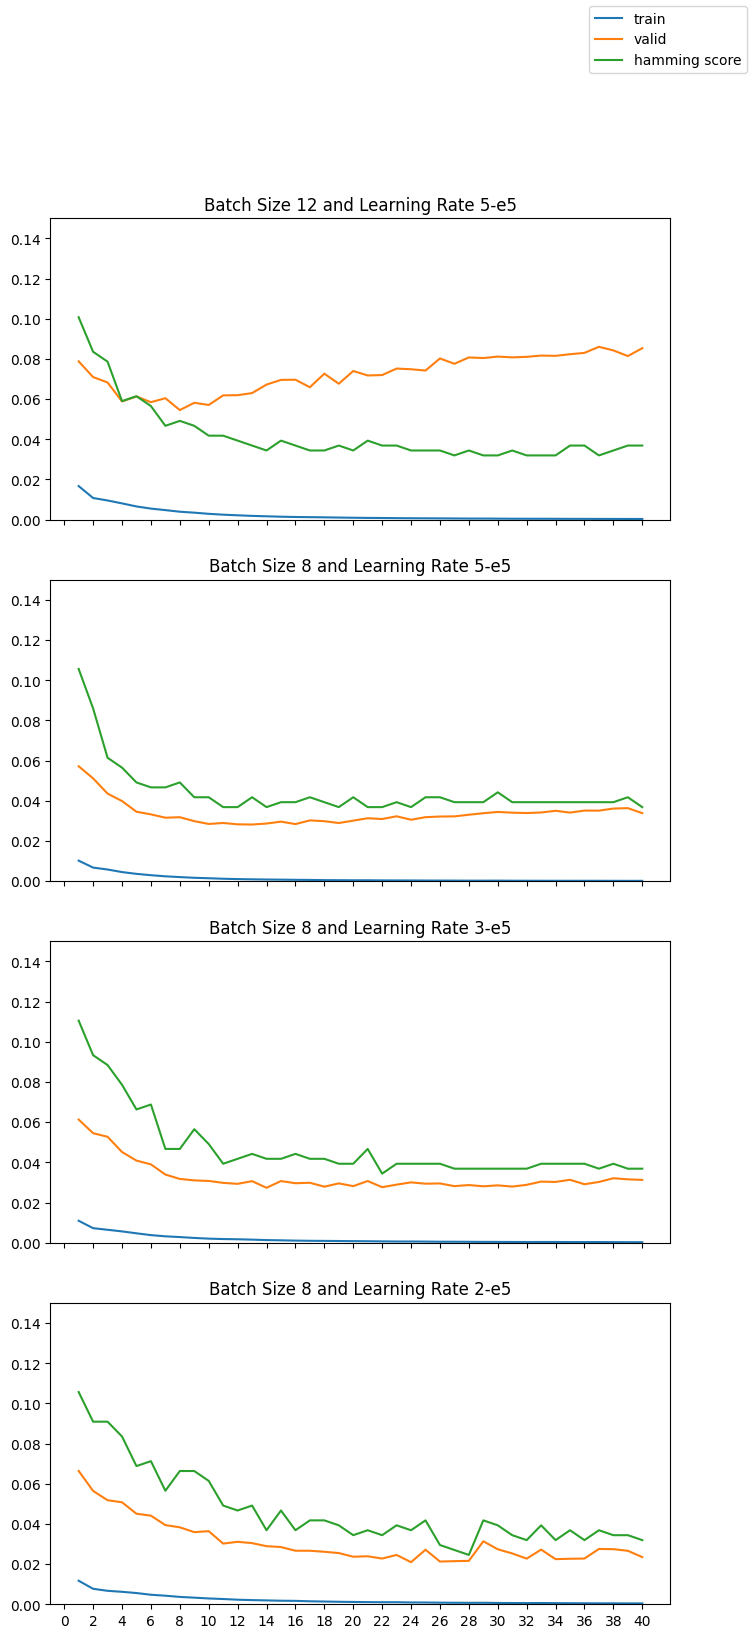

In [54]:
fig, ax = plt.subplots(4, 1, sharey=True, sharex=True)
fig.set_figheight(18)
fig.set_figwidth(8)
# fig.suptitle("MACRO CONTENT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0,0.15)

ax[0].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["train_loss"], label="train")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["hamming"], label="hamming score")
fig.legend()
xticks(np.arange(0, 41, 2))
ax[2].set_ylim(0,0.15)

ax[2].title.set_text("Batch Size 8 and Learning Rate 3-e5")
ax[2].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[2].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[2].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])

xticks(np.arange(0, 41, 2))

ax[3].set_ylim(0,0.15)

ax[3].title.set_text("Batch Size 8 and Learning Rate 2-e5")
ax[3].plot(df_model_2_batch_8.index, df_model_2_batch_8["train_loss"])
ax[3].plot(df_model_2_batch_8.index, df_model_2_batch_8["valid_loss"])
ax[3].plot(df_model_2_batch_8.index, df_model_2_batch_8["hamming"])

xticks(np.arange(0, 41, 2))

ax[1].set_ylim(0,0.15)

ax[1].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[1].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"])
ax[1].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"])
ax[1].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"])


xticks(np.arange(0, 41, 2))
# plt.legend("upper left")
# fig.legend()

plt.show()